# Parking Occupancy Preprocessing
This notebook performs the full preprocessing workflow for predicting hourly parking occupancy by street.

## Set Up Environment
Import core libraries, configure display options, and define canonical paths for raw and derived datasets.

In [1]:
# Core libraries and configuration
from pathlib import Path
import json
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

RAW_DATA_DIR = Path("../data/raw")
PROCESSED_DIR = Path("../data/processed")
ARTIFACT_DIR = Path("../models/occupancy")

RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

RAW_FILES = [
    RAW_DATA_DIR / "parking_transactions_2025-07.csv",
    RAW_DATA_DIR / "parking_transactions_2025-08.csv",
    RAW_DATA_DIR / "parking_transactions_2025-09.csv",
    RAW_DATA_DIR / "parking_transactions_2025-10.csv",
]
RAW_FILES = [path for path in RAW_FILES if path.exists()]
RAW_FILES

[PosixPath('../data/raw/parking_transactions_2025-07.csv'),
 PosixPath('../data/raw/parking_transactions_2025-08.csv'),
 PosixPath('../data/raw/parking_transactions_2025-09.csv'),
 PosixPath('../data/raw/parking_transactions_2025-10.csv')]

## Load Raw Data
Read monthly transaction exports, concatenate them into a single DataFrame, and inspect the schema.

In [2]:
def load_month(path: Path) -> pd.DataFrame:
    """Load a single month of parking transactions."""
    df = pd.read_csv(path, parse_dates=["startDtm", "endDtm"])
    df["sourceStreetDisplayName"] = df["sourceStreetDisplayName"].astype(str).str.strip()
    if df["startDtm"].dt.tz is None:
        df["startDtm"] = df["startDtm"].dt.tz_localize("UTC")
    else:
        df["startDtm"] = df["startDtm"].dt.tz_convert("UTC")
    if df["endDtm"].dt.tz is None:
        df["endDtm"] = df["endDtm"].dt.tz_localize("UTC")
    else:
        df["endDtm"] = df["endDtm"].dt.tz_convert("UTC")
    print(f"Loaded {len(df):,} rows from {path.name}")
    return df

transactions = pd.concat([load_month(path) for path in RAW_FILES], ignore_index=True)
print(f"Combined rows: {len(transactions):,}")
display(transactions.head())
transactions.info()

Loaded 316,767 rows from parking_transactions_2025-07.csv


/var/folders/4s/_79x00ln3433_t94ty28vgl00000gn/T/ipykernel_85384/1986258319.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, parse_dates=["startDtm", "endDtm"])


Loaded 320,764 rows from parking_transactions_2025-08.csv
Loaded 305,999 rows from parking_transactions_2025-09.csv
Loaded 305,999 rows from parking_transactions_2025-09.csv
Loaded 177,805 rows from parking_transactions_2025-10.csv
Combined rows: 1,121,335
Loaded 177,805 rows from parking_transactions_2025-10.csv
Combined rows: 1,121,335


,activeStatusInd,blockNbr,dollarPerHourRate,endDtm,handicapInd,latitudeCrd,longitudeCrd,maxHoursCnt,meterId,meterManufacturerName,meterTypeDsc,metroAreaName,paymentTypeName,sideDirectionName,sourceStreetDisplayName,startDtm,statePlaneXCrd,statePlaneYCrd,timeRestrictionDsc,transactionAmt,transactionSourceCode,transactionStatusCode,zoneNbr,zoneSpaceCnt
0,False,1400.0,1.50,2025-07-01 02:11:31+00:00,False,38.892845,-77.072087,12.0,NaN,CALE,Multi,Rosslyn,APPLE_PAY,South,FAIRFAX DR,2025-07-01 00:31:31+00:00,1.188932e+07,7.011368e+06,MON - FRI 8AM - 8PM,2.50,ParkMobile,Approved,54481.0,33.0
1,False,1500.0,1.50,2025-07-01 07:09:22+00:00,False,38.859319,-77.053556,12.0,NaN,CALE,Multi,Crystal City,APPLE_PAY,West,S EADS ST,2025-07-01 00:32:22+00:00,1.189478e+07,6.999242e+06,MON - FRI 8AM - 8PM,9.94,ParkMobile,Approved,54662.0,15.0
2,False,1600.0,1.50,2025-07-01 06:14:14+00:00,False,38.892567,-77.077260,12.0,NaN,CALE,Multi,Rosslyn,APPLE_PAY,East,N QUEEN ST,2025-07-01 02:14:14+00:00,1.188785e+07,7.011244e+06,MON - FRI 8AM - 8PM,6.00,ParkMobile,Approved,54531.0,11.0
3,False,1500.0,1.50,2025-07-01 07:10:46+00:00,False,38.859170,-77.055909,12.0,NaN,CALE,Multi,Crystal City,CREDITCARD,East,S FERN ST,2025-07-01 03:40:46+00:00,1.189411e+07,6.999177e+06,MON - FRI 8AM - 8PM,5.25,ParkMobile,Approved,54340.0,26.0
4,False,1000.0,0.75,2025-07-01 07:27:48+00:00,False,38.885636,-77.087971,12.0,NaN,CALE,Multi,Courthouse,CREDITCARD,East,N BARTON ST,2025-07-01 03:47:48+00:00,1.188484e+07,7.008673e+06,MON - FRI 8AM - 8PM,2.75,ParkMobile,Approved,54385.0,14.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121335 entries, 0 to 1121334
Data columns (total 24 columns):
 #   Column                   Non-Null Count    Dtype              
---  ------                   --------------    -----              
 0   activeStatusInd          1121335 non-null  bool               
 1   blockNbr                 1121186 non-null  float64            
 2   dollarPerHourRate        1058057 non-null  float64            
 3   endDtm                   1119989 non-null  datetime64[ns, UTC]
 4   handicapInd              1121186 non-null  object             
 5   latitudeCrd              1121186 non-null  float64            
 6   longitudeCrd             1121186 non-null  float64            
 7   maxHoursCnt              1058057 non-null  float64            
 8   meterId                  249868 non-null   object             
 9   meterManufacturerName    1057987 non-null  object             
 10  meterTypeDsc             1057417 non-null  object             
 11

## Inspect Data Quality
Assess distributions, summary statistics, and visualize missingness to understand data quality baselines.

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
sourceStreetDisplayName,1121335,134,WILSON BLVD,115868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transactionAmt,1121335.0,NaN,NaN,NaN,3.231134,0.01,1.31,2.51,4.25,52.85,2.858847
paymentTypeName,1121331,11,APPLE_PAY,464047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transactionStatusCode,1080561,3,Approved,871467,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zoneNbr,1121012.0,NaN,NaN,NaN,54378.972136,54001.0,54209.0,54348.0,54510.0,54923.0,222.431086
meterId,249868,1348,BOZ03N,2822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
startDtm,1121335,NaN,NaN,NaN,2025-08-24 19:36:42.762394624+00:00,2025-07-01 00:31:31+00:00,2025-07-29 08:03:00+00:00,2025-08-23 18:11:00+00:00,2025-09-20 14:01:14.500000+00:00,2025-10-20 07:53:03+00:00,NaN
endDtm,1119989,NaN,NaN,NaN,2025-08-24 21:25:41.301687552+00:00,2025-07-01 02:11:31+00:00,2025-07-29 09:41:00+00:00,2025-08-23 19:59:00+00:00,2025-09-20 15:48:08+00:00,2025-10-20 12:00:00+00:00,NaN


,missing_rate
sourceStreetDisplayName,0.00%
transactionAmt,0.00%
paymentTypeName,0.00%
transactionStatusCode,3.64%
zoneNbr,0.03%
meterId,77.72%
startDtm,0.00%
endDtm,0.12%


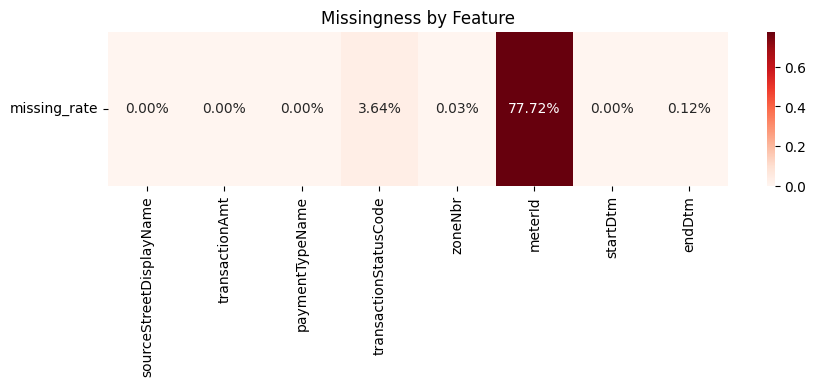

In [3]:
cols_to_profile = [
    "sourceStreetDisplayName",
    "transactionAmt",
    "paymentTypeName",
    "transactionStatusCode",
    "zoneNbr",
    "meterId",
    "startDtm",
    "endDtm",
]

profile_df = transactions[cols_to_profile].copy()
profile_summary = profile_df.describe(include="all").transpose()
display(profile_summary)

missing_rates = profile_df.isna().mean().to_frame(name="missing_rate")
display(missing_rates.style.format({"missing_rate": "{:.2%}"}))

plt.figure(figsize=(10, 2))
sns.heatmap(missing_rates.T, annot=True, fmt=".2%", cmap="Reds")
plt.title("Missingness by Feature")
plt.yticks(rotation=0)
plt.show()

## Handle Missing Values
Construct imputers for numerical and categorical fields to address nulls before feature encoding.

In [4]:
transactions_imputed = transactions.copy()
transactions_imputed["transactionAmt"] = pd.to_numeric(transactions_imputed["transactionAmt"], errors="coerce")

numeric_features = ["transactionAmt"]
categorical_features = [
    "paymentTypeName",
    "transactionStatusCode",
    "zoneNbr",
    "meterId",
    "sourceStreetDisplayName",
]

numeric_imputer = SimpleImputer(strategy="median")
categorical_imputer = SimpleImputer(strategy="most_frequent")

transactions_imputed[numeric_features] = numeric_imputer.fit_transform(transactions_imputed[numeric_features])
transactions_imputed[categorical_features] = categorical_imputer.fit_transform(transactions_imputed[categorical_features])

imputation_report = transactions_imputed[categorical_features + numeric_features].isna().mean().to_frame(name="missing_rate_after")
display(imputation_report.transpose())

,paymentTypeName,transactionStatusCode,zoneNbr,meterId,sourceStreetDisplayName,transactionAmt
missing_rate_after,0.0,0.0,0.0,0.0,0.0,0.0


## Encode Categorical Variables
Set up encoding pipelines for street-level features while preserving unseen-category handling.

In [5]:
onehot_features = ["paymentTypeName", "transactionStatusCode"]
ordinal_features = ["zoneNbr", "meterId", "sourceStreetDisplayName"]

categorical_encoder = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_features),
        ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
 )

sample_to_encode = transactions_imputed[onehot_features + ordinal_features].head(10_000)
encoded_preview = categorical_encoder.fit_transform(sample_to_encode)
print(f"Encoded shape (preview): {encoded_preview.shape}")

Encoded shape (preview): (10000, 14)


## Scale Numerical Features
Apply standardization to continuous variables to stabilize downstream model training.

In [6]:
scaler = StandardScaler()
scaled_values = scaler.fit_transform(transactions_imputed[numeric_features])
pd.DataFrame(scaled_values, columns=[f"{col}_scaled" for col in numeric_features]).head()

,transactionAmt_scaled
0,-0.255745
1,2.346704
2,0.968526
3,0.706182
4,-0.168297


## Engineer Features
Derive hourly occupancy counts per street and enrich with calendar context for modeling.

In [7]:
def build_hourly_occupancy(df: pd.DataFrame) -> pd.DataFrame:
    """Expand transactions into street-hour occupancy counts."""
    subset = df.loc[df["endDtm"] > df["startDtm"]].copy()
    subset["start_hour"] = subset["startDtm"].dt.floor("h")
    subset["end_hour"] = (subset["endDtm"] - pd.Timedelta(seconds=1)).dt.floor("h")
    subset = subset.loc[subset["end_hour"] >= subset["start_hour"]]
    if subset.empty:
        return pd.DataFrame(columns=["street", "hour", "occupancy"])

    durations = ((subset["end_hour"] - subset["start_hour"]) / pd.Timedelta(hours=1)).astype(int) + 1
    durations = durations.clip(lower=1)

    expanded_index = subset.index.repeat(durations)
    expanded = subset.loc[expanded_index, ["sourceStreetDisplayName", "start_hour"]].copy()
    offsets = np.concatenate([np.arange(d, dtype="int16") for d in durations.to_numpy()])
    expanded["hour"] = expanded["start_hour"].array + pd.to_timedelta(offsets, unit="h")
    expanded = expanded.rename(columns={"sourceStreetDisplayName": "street"})
    expanded = expanded.drop(columns="start_hour")

    hourly = expanded.groupby(["street", "hour"], as_index=False).size().rename(columns={"size": "occupancy"})
    hourly["day_of_week"] = hourly["hour"].dt.dayofweek
    hourly["hour_of_day"] = hourly["hour"].dt.hour
    hourly["month"] = hourly["hour"].dt.month
    hourly["is_weekend"] = (hourly["day_of_week"] >= 5).astype(int)
    hourly["hour_sin"] = np.sin(2 * np.pi * hourly["hour_of_day"] / 24)
    hourly["hour_cos"] = np.cos(2 * np.pi * hourly["hour_of_day"] / 24)
    return hourly.sort_values(["street", "hour"]).reset_index(drop=True)

hourly_occupancy = build_hourly_occupancy(transactions_imputed)
hourly_occupancy.head()

,street,hour,occupancy,day_of_week,hour_of_day,month,is_weekend,hour_sin,hour_cos
0,10th ST N,2025-07-01 06:00:00+00:00,1,1,6,7,0,1.000000,6.123234e-17
1,10th ST N,2025-07-01 07:00:00+00:00,18,1,7,7,0,0.965926,-2.588190e-01
2,10th ST N,2025-07-01 08:00:00+00:00,63,1,8,7,0,0.866025,-5.000000e-01
3,10th ST N,2025-07-01 09:00:00+00:00,82,1,9,7,0,0.707107,-7.071068e-01
4,10th ST N,2025-07-01 10:00:00+00:00,98,1,10,7,0,0.500000,-8.660254e-01


## Split Dataset
Partition the engineered features into train, validation, and test subsets with deterministic shuffling.

In [8]:
if hourly_occupancy.empty:
    raise ValueError("No hourly occupancy rows were generated; ensure raw data is loaded.")

feature_columns = [
    "street",
    "day_of_week",
    "hour_of_day",
    "month",
    "is_weekend",
    "hour_sin",
    "hour_cos",
]
target_column = "occupancy"

X = hourly_occupancy[feature_columns].copy()
y = hourly_occupancy[target_column].copy()

X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=2025,
    stratify=X["street"],
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1765,  # results in ~15% validation overall
    random_state=2025,
    stratify=X_temp["street"],
)

len(X_train), len(X_val), len(X_test)

(108692, 23296, 23293)

In [9]:
occupancy_preprocessor = ColumnTransformer(
    transformers=[
        ("street", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["street"]),
        (
            "time_features",
            "passthrough",
            ["day_of_week", "hour_of_day", "month", "is_weekend", "hour_sin", "hour_cos"],
        ),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
 )

preprocessing_pipeline = Pipeline(
    steps=[
        ("encoder", occupancy_preprocessor),
        ("scaler", StandardScaler()),
    ]
)

X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_val_processed = preprocessing_pipeline.transform(X_val)
X_test_processed = preprocessing_pipeline.transform(X_test)
X_train_processed.shape, X_val_processed.shape, X_test_processed.shape

((108692, 7), (23296, 7), (23293, 7))

## Persist Preprocessing Artifacts
Store processed datasets and fitted transformers for reuse during model training and inference.

In [10]:
feature_names = preprocessing_pipeline.get_feature_names_out()
train_df = pd.DataFrame(X_train_processed, columns=feature_names)
train_df[target_column] = y_train.reset_index(drop=True)

val_df = pd.DataFrame(X_val_processed, columns=feature_names)
val_df[target_column] = y_val.reset_index(drop=True)

test_df = pd.DataFrame(X_test_processed, columns=feature_names)
test_df[target_column] = y_test.reset_index(drop=True)

hourly_path = PROCESSED_DIR / "parking_hourly_occupancy_2025-07_2025-10.csv"
train_path = PROCESSED_DIR / "occupancy_train.parquet"
val_path = PROCESSED_DIR / "occupancy_val.parquet"
test_path = PROCESSED_DIR / "occupancy_test.parquet"
pipeline_path = ARTIFACT_DIR / "preprocessing_pipeline.joblib"
imputer_path = ARTIFACT_DIR / "imputers.joblib"
metadata_path = ARTIFACT_DIR / "preprocessing_metadata.json"

hourly_occupancy.to_csv(hourly_path, index=False)
train_df.to_parquet(train_path, index=False)
val_df.to_parquet(val_path, index=False)
test_df.to_parquet(test_path, index=False)
joblib.dump(preprocessing_pipeline, pipeline_path)
joblib.dump({
    "numeric_imputer": numeric_imputer,
    "categorical_imputer": categorical_imputer,
    "scaler": scaler,
    "categorical_encoder": categorical_encoder,
}, imputer_path)

metadata = {
    "raw_files": [path.name for path in RAW_FILES],
    "rows": len(hourly_occupancy),
    "feature_columns": feature_columns,
    "target_column": target_column,
    "train_rows": len(train_df),
    "val_rows": len(val_df),
    "test_rows": len(test_df),
    "created_at": pd.Timestamp.utcnow().isoformat(),
}
with metadata_path.open("w", encoding="utf-8") as fh:
    json.dump(metadata, fh, indent=2)

train_path, val_path, test_path, pipeline_path

(PosixPath('../data/processed/occupancy_train.parquet'),
 PosixPath('../data/processed/occupancy_val.parquet'),
 PosixPath('../data/processed/occupancy_test.parquet'),
 PosixPath('../models/occupancy/preprocessing_pipeline.joblib'))